In [1]:
import torch

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [3]:
batch_size = 256

# DataLoader give a Dataset object how parameters and provides an efficent way to iterate the Dataset
train_dataset = datasets.MNIST(
    "./datasets/",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)
train_dataset, validation_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = datasets.MNIST(
    "./datasets/",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [4]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 10000)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(10000, 3000)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(3000, 1000)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(1000, 250)
        self.relu4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(250, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out


In [5]:
input_size, num_classes = 784, 10
model = NeuralNet(input_size, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(
    f"Model:{model}\nNumber of trainable parameters:{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)


Model:NeuralNet(
  (fc1): Linear(in_features=784, out_features=10000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=10000, out_features=3000, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=3000, out_features=1000, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=1000, out_features=250, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=250, out_features=10, bias=True)
)
Number of trainable parameters:41,106,760


In [6]:
# to save val and training loss for each history
history_train_loss = []
history_val_loss = []
history_val_acc = []

# training
for epoch in range(50):  # loop over the dataset multiple times
    tot_train_loss, tot_train_samples = 0.0, 0
    tot_val_loss, tot_val_samples = 0.0, 0
    tot_val_prediction = 0
    # test
    for i, data in enumerate(train_loader):
        # Step 1: Retrieving a batch of input from the dataloader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.size(0), 784)
        tot_train_samples += inputs.size(0)

        # Step 2: Zeroing the parameter gradients - always do this before doing loss.backward()!!!
        optimizer.zero_grad()
        # Step 3: forward (get network prediction)
        outputs = model(inputs)
        outputs = outputs.to(device)

        # Step 4: compute loss
        loss = criterion(outputs, labels)
        # Step 5: Compute gradients for each of the model learnable parameters
        loss.backward()
        # Step 4: Update model parameters according to the gradients
        optimizer.step()

        # logging, accumulating loss value for current epoch...
        tot_train_loss += loss.item() * inputs.size(0)

    # validation
    for i, data in enumerate(validation_loader):
        # Step 1: Retrieving a batch of input from the dataloader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.size(0), 784)
        tot_val_samples += inputs.size(0)

        # Step 2: Zeroing the parameter gradients - always do this before doing loss.backward()!!!
        optimizer.zero_grad()
        # Step 3: forward (get network prediction)
        outputs = model(inputs)
        outputs = outputs.to(device)

        y_pred = torch.argmax(outputs, dim=1)
        tot_val_prediction += torch.sum(y_pred == labels)

        # Step 4: compute loss
        loss = criterion(outputs.to(device), labels)

        # logging, accumulating loss value for current epoch...
        tot_val_loss += loss.item() * inputs.size(0)

    # End epoch here
    train_loss = tot_train_loss * 1.0 / float(tot_train_samples)
    val_loss = tot_val_loss * 1.0 / float(tot_val_samples)
    val_acc = tot_val_prediction * 1.0 / float(tot_val_samples)

    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_val_acc.append(val_acc)

    print(
        f"Epoch {epoch}:\nTrain loss:{train_loss:>6.3f}\nVal loss:{val_loss:>8.3f}\nVal acc:{val_acc:>9.3f}")


Epoch 0:
Train loss: 2.186
Val loss:   1.923
Val acc:    0.680
Epoch 1:
Train loss: 1.246
Val loss:   0.734
Val acc:    0.819
Epoch 2:
Train loss: 0.555
Val loss:   0.460
Val acc:    0.874
Epoch 3:
Train loss: 0.396
Val loss:   0.370
Val acc:    0.895
Epoch 4:
Train loss: 0.333
Val loss:   0.329
Val acc:    0.902
Epoch 5:
Train loss: 0.296
Val loss:   0.296
Val acc:    0.913
Epoch 6:
Train loss: 0.270
Val loss:   0.273
Val acc:    0.919
Epoch 7:
Train loss: 0.249
Val loss:   0.256
Val acc:    0.924
Epoch 8:
Train loss: 0.232
Val loss:   0.241
Val acc:    0.928
Epoch 9:
Train loss: 0.217
Val loss:   0.232
Val acc:    0.930
Epoch 10:
Train loss: 0.204
Val loss:   0.219
Val acc:    0.937
Epoch 11:
Train loss: 0.191
Val loss:   0.205
Val acc:    0.941
Epoch 12:
Train loss: 0.181
Val loss:   0.195
Val acc:    0.945
Epoch 13:
Train loss: 0.171
Val loss:   0.186
Val acc:    0.947
Epoch 14:
Train loss: 0.161
Val loss:   0.179
Val acc:    0.947
Epoch 15:
Train loss: 0.152
Val loss:   0.176
Val 

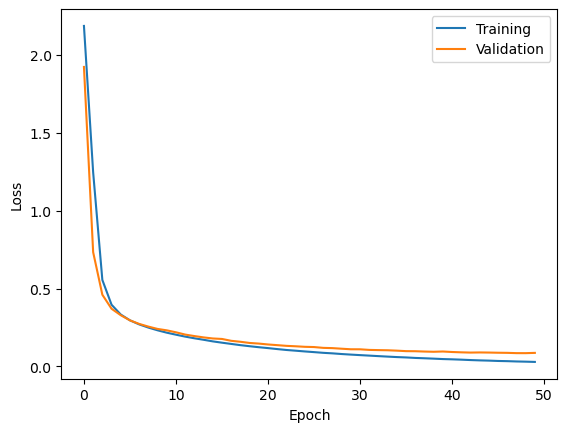

In [23]:
from matplotlib import pyplot as plt

plt.plot(range(len(history_train_loss)), history_train_loss, label='Training')
plt.plot(range(len(history_val_loss)), history_val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(history_t)), history_val_acc, label='Training')
plt.plot(range(len(history_val_acc)), history_val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


In [7]:
# test
tot_test_loss, tot_test_samples = 0.0, 0
tot_test_prediction = 0
for i, data in enumerate(test_loader):
    # Step 1: Retrieving a batch of input from the dataloader
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.view(inputs.size(0), 784)
    tot_test_samples += inputs.size(0)

    # Step 2: Zeroing the parameter gradients - always do this before doing loss.backward()!!!
    optimizer.zero_grad()
    # Step 3: forward (get network prediction)
    outputs = model(inputs)
    outputs = outputs.to(device)

    y_pred = torch.argmax(outputs, dim=1)
    tot_test_prediction += torch.sum(y_pred == labels)

    # Step 4: compute loss
    loss = criterion(outputs.to(device), labels)

    # logging, accumulating loss value for current epoch...
    tot_test_loss += loss.item() * inputs.size(0)

print(
    f"Test loss:{(tot_test_loss * 1.0 / float(tot_test_samples)):>6.3f}\nVal acc:{(tot_test_prediction / tot_test_samples):>8.3f}"
)


Test loss: 0.079
Val acc:   0.975
